In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost as xgb
!pip install catboost
import catboost
!pip install -U imbalanced-learn
import imblearn

import pylab
pylab.rcParams['figure.figsize'] = (15, 10)
import matplotlib.pyplot as plt
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

from IPython.display import clear_output
clear_output()

In [3]:
itog = np.loadtxt('/content/drive/MyDrive/Small.csv', delimiter=",")

In [ ]:
print(itog.shape)

(100000, 289)


Итак, мы имеем 100 тысяч объектов с 288 признаками

In [4]:
df = pd.DataFrame(itog, columns=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,279,280,281,282,283,284,285,286,287,288
0,281.1261,5.2019,4.9755,4.8077,4.6789,4.6716,4.4699,4.4669,272.5268,4.6808,...,0.9458,0.0000,-0.6543,0.0427,0.4482,0.7899,1.0149,1.1537,1.4483,0.0
1,336.6726,5.0464,4.8182,4.7258,4.5225,4.5546,4.4657,4.5582,328.6995,4.1517,...,1.0008,0.0095,1.3937,1.3188,1.3582,1.2059,1.3286,1.4715,0.8529,0.0
2,290.2059,5.0463,4.7287,4.6207,4.5631,4.5707,4.4580,4.3681,255.7782,3.7374,...,1.5204,-0.0156,1.3963,1.3386,1.4358,1.4311,1.3677,1.6846,1.7238,0.0
3,340.9563,5.1230,4.8917,4.5914,4.6239,4.5577,4.4663,4.4310,319.4096,4.6115,...,1.7294,0.0000,-0.0617,1.1793,1.1271,1.3000,1.3077,1.5584,1.6281,0.0
4,276.8253,5.1806,4.8622,4.7099,4.5290,4.6399,4.3291,4.2316,257.5264,3.8630,...,1.6827,0.0000,0.3654,1.2722,1.4114,1.5722,1.5142,1.1071,1.5082,0.0


Бросается в глаза то, что признаки имеют значения в разных диапазонах, а значит нам понадобится нормирование, если мы хотим использовать что-то, кроме деревьев (а мы хотим).

In [ ]:
df.isna().sum()

0      0
1      0
2      0
3      0
4      0
      ..
284    0
285    0
286    0
287    0
288    0
Length: 289, dtype: int64

Кажется, пропусков нет.

Посмотрим еще на баланс классов

In [5]:
neg, pos = df[288].value_counts()
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 100000
    Positive: 8665 (8.66% of total)



<ipython-input-13-1974dea6f1a4>:4: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax.bar(np.arange(len(column)), column, color='cm')


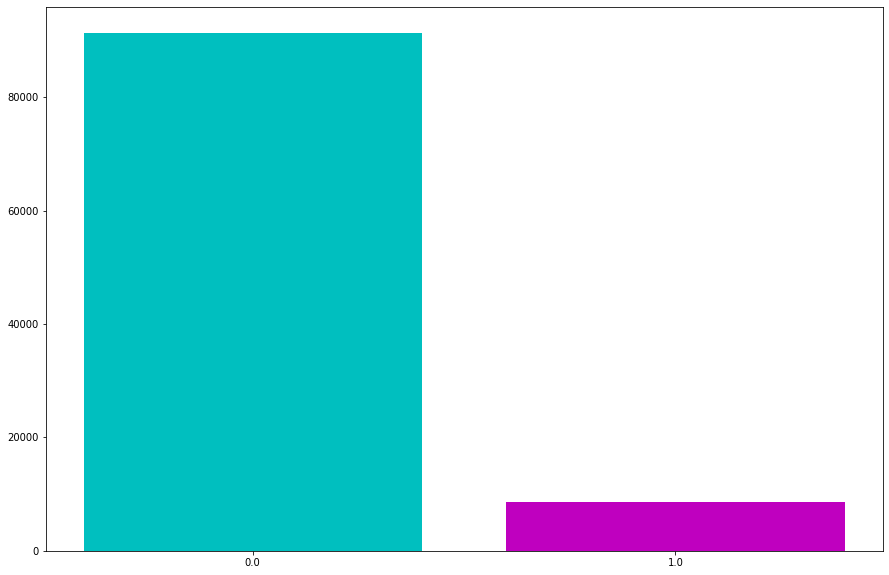

In [ ]:
column = df[288].value_counts()
names = df[288].value_counts().index.tolist()
fig, ax = plt.subplots()
ax.bar(np.arange(len(column)), column, color='cm')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)
plt.show()

Мы видим, что объектов класса 0 примерно в 10 раз больше, чем объектов класса 1, т.е. наблюдается дисбаланс классов.

In [6]:
out = itog[:,288]
itog = itog[:,:288]

In [7]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = tf.cast(K.sum(K.round(K.clip(y_true * y_pred, 0, 1))), tf.float32)
    possible_positives = tf.cast(K.sum(K.round(K.clip(y_true, 0, 1))), tf.float32)
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = tf.cast(K.sum(K.round(K.clip(y_true * y_pred, 0, 1))), tf.float32)
    predicted_positives = tf.cast(K.sum(K.round(K.clip(y_pred, 0, 1))), tf.float32)
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(itog, out, test_size=0.2, random_state=42)

Вроде по науке нормализацию надо проводить по тренировочным данным и fit к тестовым применять на основе обученного на тренировочных данных скейлера.

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Посчитаем веса для классов

In [10]:
# вдохновлено этим
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.55
Weight for class 1: 5.77


Начнем с нейронной сети с линейными слоями. Для борьбы с переобучением добавим слой Dropout.

In [11]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(288,)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[f1_m])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="mymodel_{epoch}", monitor='val_loss', verbose=1, save_best_only=True)

В fit добавим веса классов.



In [ ]:
results = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), 
                    batch_size=1000, epochs=200, 
                    callbacks=[model_checkpoint], class_weight=class_weight)

Epoch 1/200
79/80 [============================>.] - ETA: 0s - loss: 0.6987 - f1_m: 0.2086
Epoch 1: val_loss improved from inf to 0.49224, saving model to mymodel_1
80/80 [==============================] - 4s 30ms/step - loss: 0.6981 - f1_m: 0.2088 - val_loss: 0.4922 - val_f1_m: 0.4796
Epoch 2/200
79/80 [============================>.] - ETA: 0s - loss: 0.5235 - f1_m: 0.3225
Epoch 2: val_loss improved from 0.49224 to 0.34553, saving model to mymodel_2
80/80 [==============================] - 2s 28ms/step - loss: 0.5230 - f1_m: 0.3234 - val_loss: 0.3455 - val_f1_m: 0.5806
Epoch 3/200
80/80 [==============================] - ETA: 0s - loss: 0.4254 - f1_m: 0.4067
Epoch 3: val_loss improved from 0.34553 to 0.25663, saving model to mymodel_3
80/80 [==============================] - 2s 25ms/step - loss: 0.4254 - f1_m: 0.4067 - val_loss: 0.2566 - val_f1_m: 0.6477
Epoch 4/200
80/80 [==============================] - ETA: 0s - loss: 0.3577 - f1_m: 0.4749
Epoch 4: val_loss improved from 0.25663 

Лучший результат из 200 относится к 164 эпохе.

In [ ]:
def display_f1_m():
    plt.plot(results.history['f1_m'])
    plt.plot(results.history['val_f1_m'])

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def display_loss():
    plt.plot(results.history['loss'])
    plt.plot(results.history['val_loss'])

    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

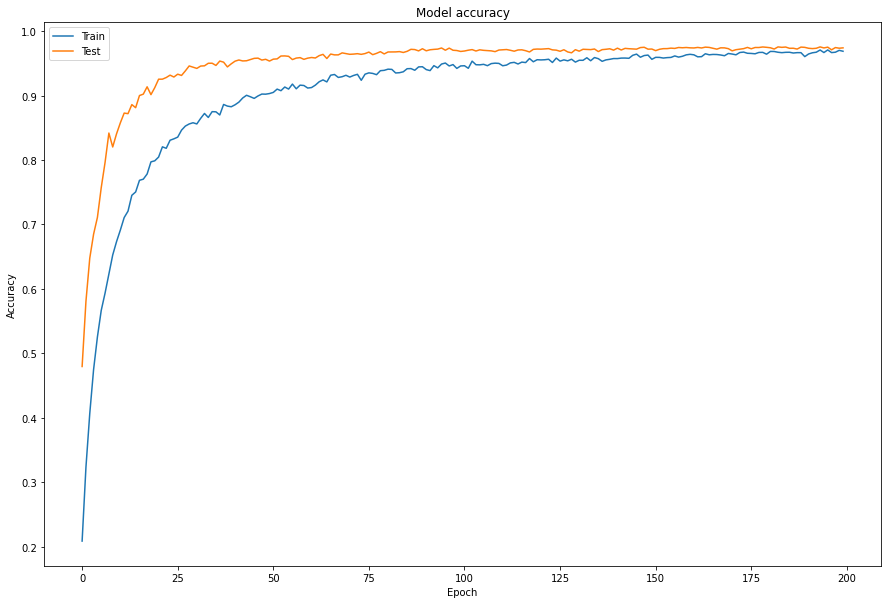

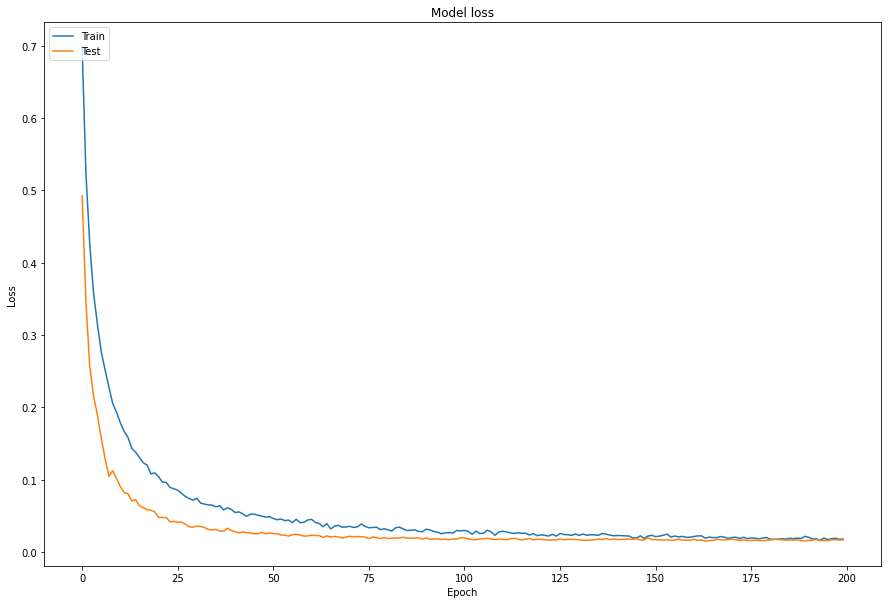

In [ ]:
display_f1_m()
display_loss()

Дропаут - вещь.

Кстати, раз уж у нас лучшая эпоха была не последняя, а 164, сохраним f1-меру для нее

In [ ]:
f1_1 = results.history['val_f1_m'][163]

In [ ]:
print(f1_1)

0.9750153422355652


In [17]:
# на случай последующих экспериментов, чтобы не считать много раз модель
f1_1 = 0.9750153422355652

Взвешенный случайный лес

In [ ]:
model_RF_bal = RandomForestClassifier(n_estimators=500, 
                                      class_weight=class_weight, random_state=42)
# model_RF_bal = RandomForestClassifier(class_weight="balanced", random_state=42)
model_RF_bal.fit(X_train, Y_train)
predictions_rf = model_RF_bal.predict_proba(X_test)[:, 1]

In [ ]:
f1_2 = float(f1_m(Y_test, K.round(predictions_rf)))
print(f1_2)

0.7803508639335632


Лес без взвешивания

In [ ]:
model_RF = RandomForestClassifier(n_estimators=500, random_state=42)
model_RF.fit(X_train, Y_train)
predictions_rf = model_RF.predict_proba(X_test)[:, 1]

In [ ]:
f1_2 = float(f1_m(Y_test, K.round(predictions_rf)))
print(f1_2)

0.7857391238212585


Одинокое дерево ниже и того лучше

Взвешенный градиентный бустинг

In [ ]:
# model_XGB = xgb.XGBClassifier(sample_weight=class_weight, random_state=42)
model_XGB = xgb.XGBClassifier(n_estimators=1500, 
                              class_weight=class_weight, random_state=42)
model_XGB.fit(X_train, Y_train)
predictions_xgb = model_XGB.predict_proba(X_test)[:, 1]

In [ ]:
f1_3 = float(f1_m(Y_test, K.round(predictions_xgb)))
print(f1_3)

0.9414575099945068


Попробуем градиентный бустинг из sklearn

In [ ]:
model_gb = GradientBoostingClassifier(n_estimators=1500, random_state=42) # тут как будто не предполагается учет несбалансированных классов
model_gb.fit(X_train, Y_train) # работает больше часа
predictions_gb = model_gb.predict_proba(X_test)[:, 1]

In [ ]:
f1_16 = float(f1_m(Y_test, K.round(predictions_gb)))
print(f1_16)

0.9244713187217712


Раз у нас хорошо работает нейросеть с линейными слоями, возникла идея попробовать линейный классификатор из методов классического машинного обучения. Попробуем метод опорных векторов, за нелинейность в нем будет отвечать ядро (радиально-базисная функция).

In [ ]:
svm = SVC(kernel='rbf', class_weight=class_weight, random_state=42)
svm.fit(X_train, Y_train)
predictions_svm = svm.predict(X_test)

In [ ]:
f1_4 = float(f1_m(Y_test, K.round(predictions_svm)))
print(f1_4)

0.9391303658485413


In [ ]:
svm = SVC(kernel='rbf', probability=True, 
          class_weight=class_weight, random_state=42) 
svm.fit(X_train, Y_train) # больше часа
predictions_svm_ = svm.predict_proba(X_test)[:, 1]

In [ ]:
f1_5 = float(f1_m(Y_test, K.round(predictions_svm_)))
print(f1_5)

0.9503176808357239


Расчет вероятностей существенно увеличивает время работы...

Мягкий классификатор оказался неплох

In [18]:
# на случай последующих экспериментов, чтобы не считать много раз модель
f1_5 = 0.9503176808357239

Попробуем с ядром попроще

In [ ]:
svc_lin = SVC(kernel='linear', probability=True, class_weight=class_weight, random_state=42)
svc_lin.fit(X_train, Y_train)
predictions_svc_lin = svc_lin.predict_proba(X_test)[:, 1]

Ядро попроще, время выполнения - нет... На пятом часу я решила, что, возможно, выборка линейно неразделима...

In [ ]:
f1_12 = float(f1_m(Y_test, K.round(predictions_svm_)))
print(f1_12)

Из линейных классификаторов у нас также есть логистическая регрессия. Попробуем и ее.


In [ ]:
logreg = LogisticRegression(penalty='l2', class_weight=class_weight, 
                            random_state=42, solver='saga')
logreg.fit(X_train, Y_train)
predictions_logreg = logreg.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Не сошлась что ли

In [ ]:
f1_6 = float(f1_m(Y_test, K.round(predictions_logreg)))
print(f1_6)

0.206183522939682


Выглядит не очень 

Может, мне удастся настроить градиентный бустинг в катбуст...

Ниже в модели количество деревьев увеличивалось до тех пор, пока значения f-меры на тренировочных данных не перестали изменяться.

In [15]:
boosting_model = catboost.CatBoostClassifier(n_estimators=4000, 
                                             learning_rate=0.1,
                                             depth=4,
                                             eval_metric='F1',
                                             random_seed=42,
                                             class_weights=class_weight)
boosting_model.fit(X_train, Y_train)

predictions_cat = boosting_model.predict_proba(X_test)[:, 1]

0:	learn: 0.6852146	total: 91.7ms	remaining: 6m 6s
1:	learn: 0.7196323	total: 154ms	remaining: 5m 7s
2:	learn: 0.8070603	total: 227ms	remaining: 5m 2s
3:	learn: 0.8449248	total: 299ms	remaining: 4m 58s
4:	learn: 0.8640227	total: 385ms	remaining: 5m 7s
5:	learn: 0.8629636	total: 457ms	remaining: 5m 3s
6:	learn: 0.8638052	total: 531ms	remaining: 5m 3s
7:	learn: 0.8727026	total: 608ms	remaining: 5m 3s
8:	learn: 0.8728451	total: 673ms	remaining: 4m 58s
9:	learn: 0.8726766	total: 746ms	remaining: 4m 57s
10:	learn: 0.8721249	total: 825ms	remaining: 4m 59s
11:	learn: 0.8783926	total: 886ms	remaining: 4m 54s
12:	learn: 0.8889472	total: 967ms	remaining: 4m 56s
13:	learn: 0.8886508	total: 1.05s	remaining: 4m 57s
14:	learn: 0.8941621	total: 1.13s	remaining: 5m
15:	learn: 0.8960845	total: 1.21s	remaining: 5m
16:	learn: 0.8943879	total: 1.27s	remaining: 4m 57s
17:	learn: 0.8950489	total: 1.34s	remaining: 4m 56s
18:	learn: 0.8965052	total: 1.45s	remaining: 5m 4s
19:	learn: 0.8990970	total: 1.53s	rem

Кажется, он достиг предела своего великолепия на 2860-м дереве

In [16]:
f1_7 = float(f1_m(Y_test, K.round(predictions_cat)))
print(f1_7)

0.9684813022613525


In [ ]:
f1_7 = 0.9684813022613525

Большое количество деревьев творит чудеса

K ближайших соседей

In [ ]:
neigh_5 = KNeighborsClassifier(n_neighbors=5)
neigh_5.fit(X_train, Y_train)
f1_8 = float(f1_m(Y_test, K.round(neigh_5.predict_proba(X_test)[:,1])))
print(f1_8)

0.7970627546310425


In [ ]:
neigh_2 = KNeighborsClassifier(n_neighbors=2)
neigh_2.fit(X_train, Y_train)
f1_8 = float(f1_m(Y_test, K.round(neigh_2.predict_proba(X_test)[:,1])))
print(f1_8)

0.787982165813446


In [ ]:
neigh_ = KNeighborsClassifier(n_neighbors=3, weights='distance')
neigh_.fit(X_train, Y_train)
f1_8 = float(f1_m(Y_test, K.round(neigh_.predict_proba(X_test)[:,1])))
print(f1_8)

0.8346951007843018


In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3) # uniform
neigh.fit(X_train, Y_train)
f1_8 = float(f1_m(Y_test, K.round(neigh.predict_proba(X_test)[:,1])))
print(f1_8)

0.8346951007843018


Деревья решений

In [ ]:
tree = tree.DecisionTreeClassifier(class_weight=class_weight, random_state=42)
tree.fit(X_train, Y_train)
f1_9 = float(f1_m(Y_test, K.round(tree.predict_proba(X_test)[:,1])))
print(f1_9)

0.8192205429077148


Наивный байесовский классификатор

In [ ]:
nb = GaussianNB()
nb.fit(X_train, Y_train)
f1_10 = float(f1_m(Y_test, K.round(nb.predict_proba(X_test)[:,1])))
print(f1_10)

0.1783931702375412


Экстремальные деревья. Он здесь преимущественно для того, чтобы использовать его в голосующем классификаторе ниже

In [ ]:
etc = ExtraTreesClassifier(n_estimators=200, class_weight=class_weight, 
                           random_state=42)
etc.fit(X_train, Y_train)
f1_11 = float(f1_m(Y_test, K.round(etc.predict_proba(X_test)[:,1])))
print(f1_11)

0.7623796463012695


Попробуем последний эксперимент: сбалансированный лес

In [ ]:
model_BRF = imblearn.ensemble.BalancedRandomForestClassifier(n_estimators=500, 
                                                             class_weight=class_weight, 
                                                             random_state=42)
model_BRF.fit(X_train, Y_train)

BalancedRandomForestClassifier(class_weight={0: 0.5474352657798215,
                                             1: 5.770340450086555},
                               n_estimators=500, random_state=42)

In [ ]:
f1_15 = float(f1_m(Y_test, K.round(model_BRF.predict_proba(X_test)[:,1])))
print(f1_15)

0.8771738409996033


Лучше, чем взвешенный лес ранее

Можно попробовать сделать ансамбль из нескольких простых классификаторов. В целом, не самые плохие результаты показывают алгоритм k ближайших соседей, одинокое дерево. Может, вместе они повысят качество результата?

In [ ]:
boosting_model._estimator_type = "classifier"

In [ ]:
getattr(tree, "_estimator_type", None) == "classifier"


True

In [20]:
# если не хочется запускать коды выше
neigh = KNeighborsClassifier(n_neighbors=3) 
tree = tree.DecisionTreeClassifier(class_weight=class_weight, random_state=42)
etc = ExtraTreesClassifier(n_estimators=200, class_weight=class_weight, 
                           random_state=42)
model_BRF = imblearn.ensemble.BalancedRandomForestClassifier(n_estimators=500, 
                                                             class_weight=class_weight, 
                                                             random_state=42)
svm = SVC(kernel='rbf', probability=True, 
          class_weight=class_weight, random_state=42) 

In [21]:
estimators_lst = [('dt', tree), ('knn', neigh), ('etc', etc), ('brf', model_BRF), ('cat', boosting_model)]
# estimators_lst = [('dt', tree), ('knn', neigh), ('etc', etc), ('brf', model_BRF), ('svm', svm)]

voting_hard = VotingClassifier(estimators=estimators_lst, voting='hard')
voting_soft = VotingClassifier(estimators=estimators_lst, voting='soft')

In [22]:
for model in [voting_hard, voting_soft]:
    model.fit(X_train, Y_train)

Наличие метода опорных векторов ощутимо замедляет работу данного ансамбля... (прошло три часа)

In [23]:
f1_13 = float(f1_m(Y_test, K.round(voting_hard.predict(X_test))))
print(f1_13)

0.9351514577865601


In [24]:
f1_14 = float(f1_m(Y_test, K.round(voting_soft.predict_proba(X_test)[:,1])))
print(f1_14)

0.931991457939148


Результат ансамбля ниже, чем для отдельного метода опорных векторов, входящего в него.

Ниже пример результата с недообученным градиентным бустингом вместо svm.

In [ ]:
# estimators_lst = [('dt', tree), ('knn', neigh), ('etc', etc), ('brf', model_BRF), ('cat', boosting_model)] # catboost с 300 деревьями

In [ ]:
f1_13 = float(f1_m(Y_test, K.round(voting_hard.predict(X_test))))
print(f1_13)

0.9322853088378906


In [ ]:
f1_14 = float(f1_m(Y_test, K.round(voting_soft.predict_proba(X_test)[:,1])))
print(f1_14)

0.9274217486381531


В целом, получилось неплохо, но, возможно, не стоило делать ансамбль из очень похожих по сути классификаторов. 4 из 5 основаны на деревьях решений. Но скажу, что добавление несбалансированного леса и затем кат. бустинга увеличило последовательно качество классификатора.

Итоговая оценка

Из лучших выбраны полносвязная нейронная сеть, метод опорных векторов, а также градиентный бустинг от Яндекса.

In [19]:
print(f1_1, f1_5, f1_7)
print("Средняя f1 мера составляет", (f1_1+f1_5+f1_7)/3)
print("Количество баллов равно", max(min(22,(f1_1+f1_5+f1_7)*100/3-75),0))

0.9750153422355652 0.9503176808357239 0.9684813022613525
Средняя f1 мера составляет 0.9646047751108805
Количество баллов равно 21.460477511088058
